In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [14]:

filesdir = "/ocean/gsgarbi/selected_days/"

dirs = os.listdir(filesdir)

print (dirs[12][18:])
season_files = ("wfiles", "spfiles", "sufiles", "ffiles")
season_keys = ['winter', 'spring', 'summer', 'fall']
abv = {"winter": "NDJ", "spring": "FMA", "summer": "MJJ", "fall": "ASO" }

50d.npy


In [3]:
def plot(points, title = 'title', picname = "noname"):
    
    Iona = (-123.30898284912109, 49.187351226806641)
    S15 = (-123.3114, 49.130412)
    S16 = (-123.317415, 49.1214)
    xl=(-126.2,-122.2)
    yl=(47.1,51)
    
    
    cmap = plt.get_cmap('nipy_spectral')
    cmap.set_bad('burlywood')



    #prepare plot and constants
    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)
#     np.shape(points)
    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]
    griddata.shape
#     np.shape(points)[0]

    griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],
                                                  bins=[100,200],
                                                  range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    

    fig, axs = plt.subplots(1,1,figsize=(9,8))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0, vmax = vmax)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    
    axs.set_title( title + "\n Total of trajectories: {}".format( int(np.sum(griddata)) ) )
    
    el = Ellipse((2, -1), 0.5, 0.5)

    axs2.annotate(
            "IONA",
            xy=(Iona[0], Iona[1]), xytext=(50, 10),
            textcoords='offset points', ha='left', va='bottom', color = (0.937, 0.439, 0.043),
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1,1,1), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1"))

    
    plt.savefig(picname, transparent = True)
    


In [4]:
wfiles = [i for i in dirs if i[:6] in ("201602", "201603", "201604")]
spfiles = [i for i in dirs if i[:6] in ("201605", "201606", "201607")]
sufiles = [i for i in dirs if i[:6] in ("201608", "201609", "201610")]
ffiles = [i for i in dirs if i[:6] in ("201611", "201612", "201701")]

files = {'winter': wfiles, 'spring': spfiles, 'summer': sufiles, 'fall': ffiles}
seasons = {}

In [18]:
def select_files (nday):

    seasons = {}

    for season in season_keys:
        seasons [season] = []
        for file in files[season]:
            if "{}d.npy".format (nday) == file [18:]:
                month = np.load(open(filesdir + file, 'rb'))
                seasons[season].append( month )

        seasons[season] = np.array([i for seasons[season] 
                                            in seasons[season] for 
                                            i in seasons[season]])
        
    return seasons

start:  2017-06-16 20:05:26.705519


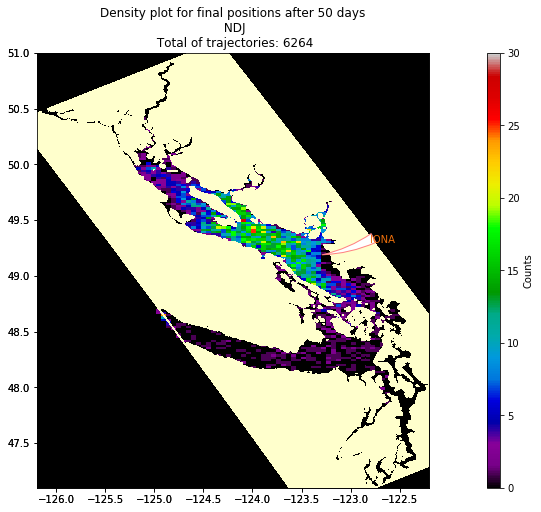

start:  2017-06-16 20:05:27.981425


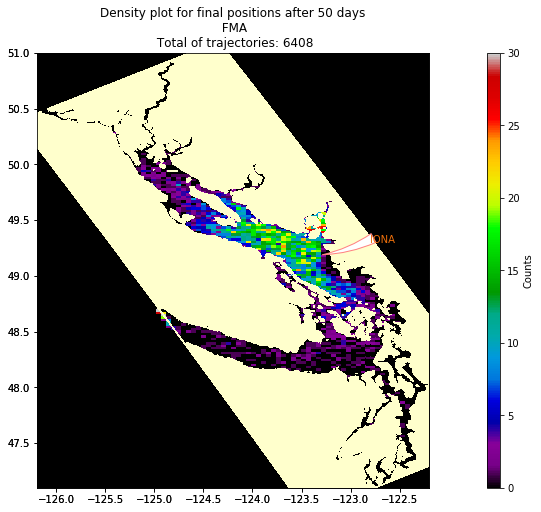

start:  2017-06-16 20:05:28.936319


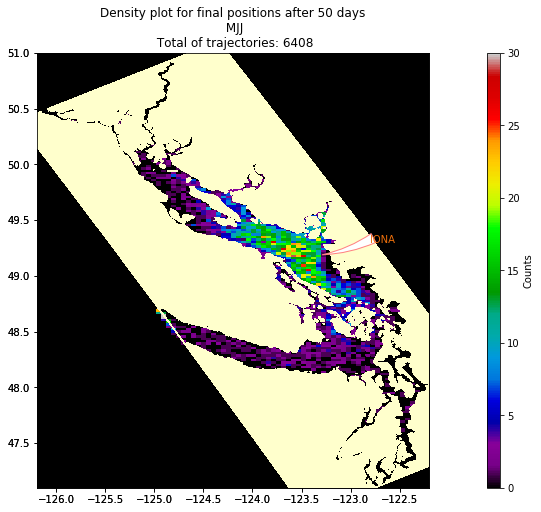

start:  2017-06-16 20:05:29.925364


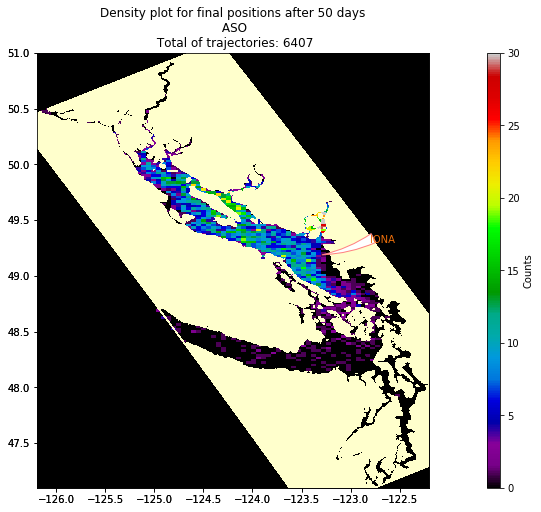

In [6]:
nday = 50
vmax = 30
for season in season_keys:
    
    seasons = select_files(nday)

    points = seasons[season]

    
    title = (
        "Density plot for final positions after {} days\n"
        " {}".format(nday, abv[season])
    )

    picname = "/ocean/gsgarbi/analysis-giorgio/plots/{}_{}".format(season, nday)

    plot (points, title, picname)
    
    plt.show()

start:  2017-06-16 20:05:31.042849


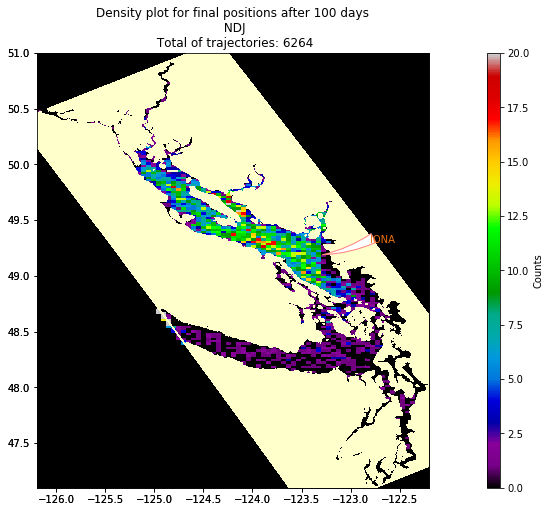

start:  2017-06-16 20:05:32.028764


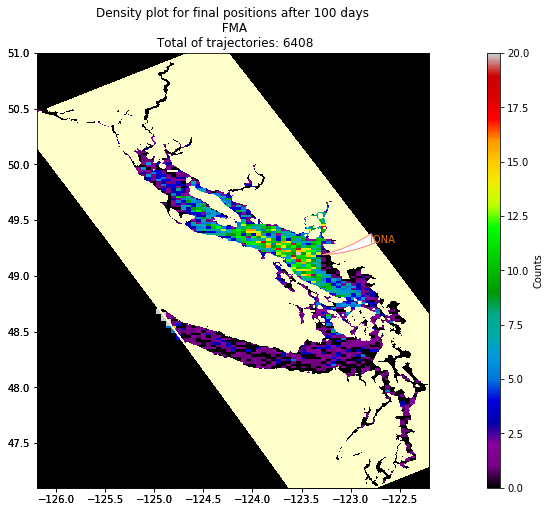

start:  2017-06-16 20:05:32.999829


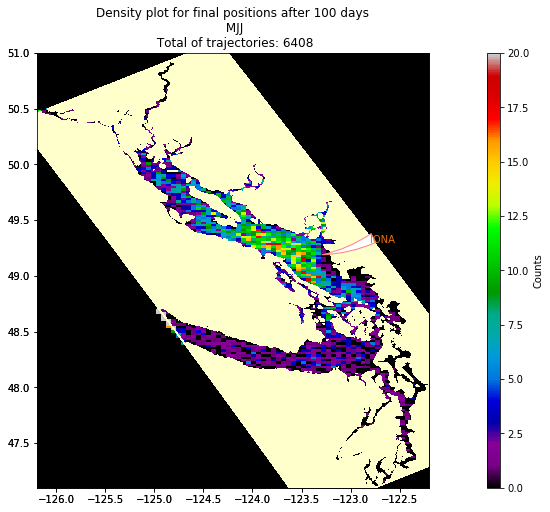

start:  2017-06-16 20:05:33.993982


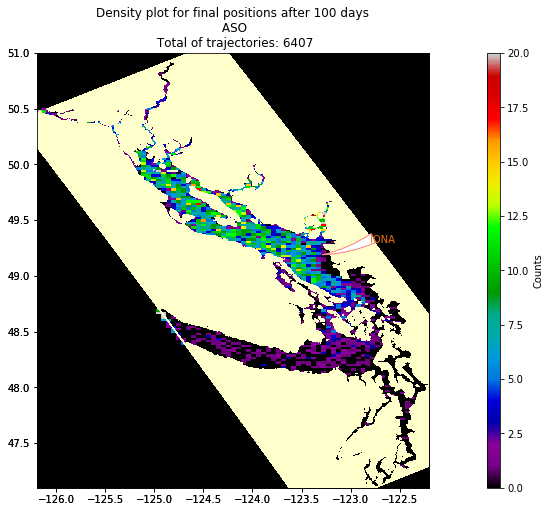

In [7]:
nday = 100
vmax = 20

for season in season_keys:
    
    seasons = select_files(nday)

    points = seasons[season]

    
    title = (
        "Density plot for final positions after {} days\n"
        " {}".format(nday, abv[season])
    )

    picname = "/ocean/gsgarbi/analysis-giorgio/plots/{}_{}".format(season, nday)

    plot (points, title, picname)
    
    plt.show()

start:  2017-06-16 20:12:25.126897


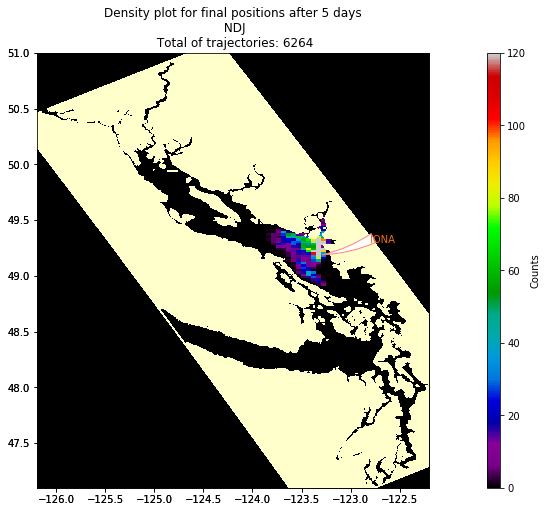

start:  2017-06-16 20:12:26.128588


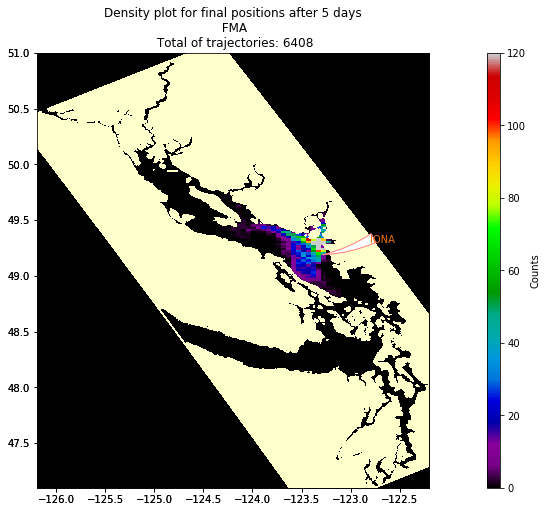

start:  2017-06-16 20:12:27.098533


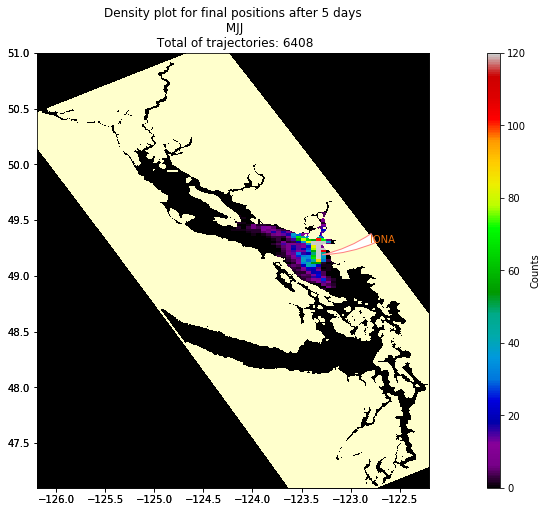

start:  2017-06-16 20:12:28.078386


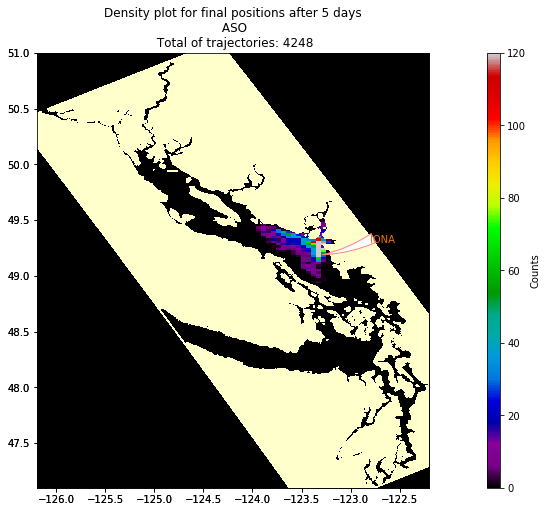

In [23]:
nday = 5
vmax = 120

for season in season_keys:
    
    seasons = select_files(nday)

    points = seasons[season]

    
    title = (
        "Density plot for final positions after {} days\n"
        " {}".format(nday, abv[season])
    )

    picname = "/ocean/gsgarbi/analysis-giorgio/plots/{}_{}".format(season, nday)

    plot (points, title, picname)
    
    plt.plot
    
    plt.show()

In [24]:
fb=nc.Dataset('NEMO-forcing/grid/bathymetry_201702.nc')

In [25]:
help (fb)

Help on Dataset object:

class Dataset(builtins.object)
 |  A netCDF `netCDF4.Dataset` is a collection of dimensions, groups, variables and
 |  attributes. Together they describe the meaning of data and relations among
 |  data fields stored in a netCDF file. See `netCDF4.Dataset.__init__` for more
 |  details.
 |  
 |  A list of attribute names corresponding to global netCDF attributes
 |  defined for the `netCDF4.Dataset` can be obtained with the
 |  `netCDF4.Dataset.ncattrs` method.
 |  These attributes can be created by assigning to an attribute of the
 |  `netCDF4.Dataset` instance. A dictionary containing all the netCDF attribute
 |  name/value pairs is provided by the `__dict__` attribute of a
 |  `netCDF4.Dataset` instance.
 |  
 |  The following class variables are read-only and should not be
 |  modified by the user.
 |  
 |  **`dimensions`**: The `dimensions` dictionary maps the names of
 |  dimensions defined for the `netCDF4.Group` or `netCDF4.Dataset` to instances of the


In [26]:
fb.variables

OrderedDict([('nav_lon', <class 'netCDF4._netCDF4.Variable'>
              float64 nav_lon(y, x)
                  units: degrees_east
              unlimited dimensions: 
              current shape = (898, 398)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('nav_lat', <class 'netCDF4._netCDF4.Variable'>
              float64 nav_lat(y, x)
                  units: degrees_north
              unlimited dimensions: 
              current shape = (898, 398)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('Bathymetry', <class 'netCDF4._netCDF4.Variable'>
              float64 Bathymetry(y, x)
                  _FillValue: 0.0
                  least_significant_digit: 0.1
                  units: metres
              unlimited dimensions: 
              current shape = (898, 398)
              filling on)])

In [28]:

= np.copy(fb.variables['Bathymetry'])


In [29]:
print (B)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
